# <font color = lightcoral>Understand current parsing and windowing logic and device new one
>    
### <font color = red>Interleaved Sliding Window - Non Overlapping
> this is the case where every 10th period is part of the test set, whereas data from periods 1-8 are part of the train set

## <font color = grey> Admin

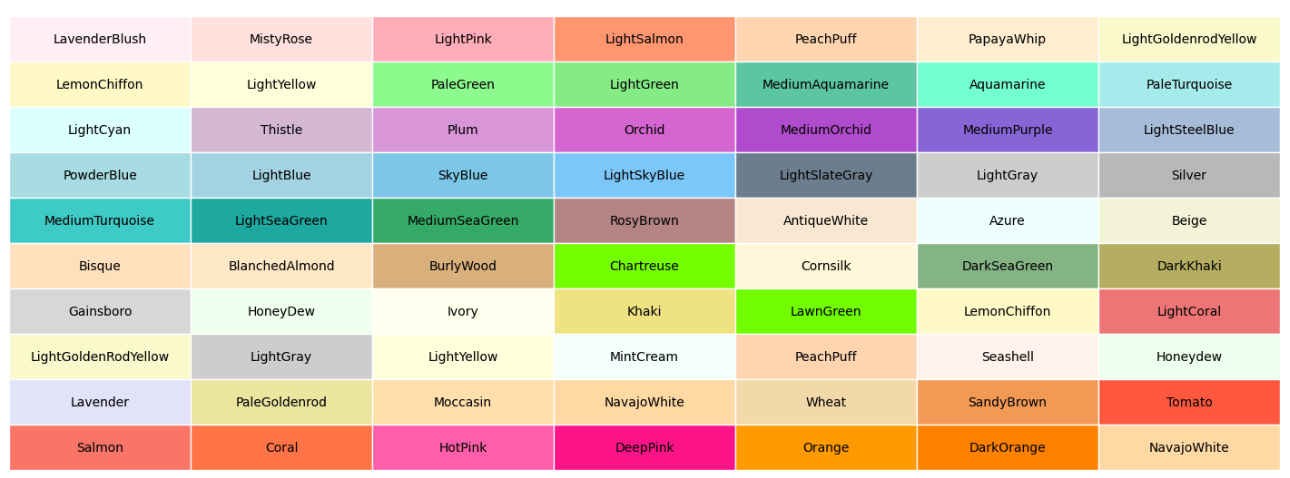

In [1]:
import pandas as pd
import os
import gzip
import time
import warnings
import os
import shutil
from datetime import datetime
# Set display option to show the full length of the column
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [2]:
# Determine the base directory based on the effective user ID
if os.geteuid() == 0:  # root user
    base_dir = '/root'
else:
    base_dir = '/home/sagemaker-user'

# Set the environment variable
os.environ['BASE_DIR'] = base_dir

# Verify the base directory
print(f"Base directory set to: {base_dir}")

Base directory set to: /home/sagemaker-user


___
# <font color = darkkhaki> (B) EDA

## <font color = lightsteelblue>EDA of Template File

In [3]:
# !cd /home/ubuntu/efs-w210-capstone-ebs/08.GIT_Repos_Anomaly_Detection/23.Library_Transformers_Logbert_HelenG_BGL/output/bgl

In [4]:
# import pandas as pd
# import time

# # Define the path to the CSV file
# # file_path = "/root/08.GIT_Repos_REF/23.Library_Transformers_Logbert_HelenG_BGL/output/bgl/BGL.log_templates.csv"

# # file_path = "/root/mnt/efs-w210-capstone/200015/08.GIT_Repos_REF/23.Library_Transformers_Logbert_HelenG_BGL/output/bgl/BGL.log_templates.csv"

# # file_path = os.path.join(base_dir, '/home/ubuntu/efs-w210-capstone-ebs/08.GIT_Repos_Anomaly_Detection/23.Library_Transformers_Logbert_HelenG_BGL/output/bgl/BGL.log_templates.csv')
# file_path = os.path.join(base_dir,'/home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/09.20240704_parsed_bgl/BGL.log_templates.csv')



# # /mnt/efs-w210-capstone/200015/

# # Start timing
# start_time = time.time()

# # Read the CSV file
# df = pd.read_csv(file_path)

# # Section 1: Preview
# print("\n" + "*"*100)
# print("********************** Section 1: Preview ******************************************")
# print("*"*100 + "\n")
# display(df.head())

# # Section 2: Shape of the DataFrame
# print("\n" + "*"*100)
# print("********************** Section 2: Shape of the DataFrame ****************************")
# print("*"*100 + "\n")
# print(df.shape)

# # Section 3: DataFrame Information
# print("\n" + "*"*100)
# print("********************** Section 3: DataFrame Information ****************************")
# print("*"*100 + "\n")
# print(df.info())

# # Section 4: Summary Statistics (without scientific notation)
# print("\n" + "*"*100)
# print("********************** Section 4: Summary Statistics *******************************")
# print("*"*100 + "\n")
# pd.options.display.float_format = '{:,.0f}'.format
# print(df.describe())

# # Section 5: Unique Event IDs
# print("\n" + "*"*100)
# print("********************** Section 5: Unique Event IDs *********************************")
# print("*"*100 + "\n")
# print(df['EventId'].nunique())

# # Section 7: Most Frequent Event Templates with Counts (ordered by occurrences)
# print("\n" + "*"*100)
# print("********************** Section 7: Most Frequent Event Templates *********************")
# print("*"*100 + "\n")
# df_sorted = df.sort_values(by='Occurrences', ascending=False).reset_index()
# df_sorted.index += 1  # Make the index start from 1
# df_sorted.rename(columns={'index': 'RowNum'}, inplace=True)
# print(df_sorted[['EventId', 'RowNum', 'EventTemplate', 'Occurrences']].head())

# # Section 8: Relevant Statistics
# print("\n" + "*"*100)
# print("********************** Section 8: Relevant Statistics *******************************")
# print("*"*100 + "\n")

# # Total number of events
# total_events = df['Occurrences'].sum()
# print(f"Total number of events: {total_events}")

# # Average occurrences per event template
# average_occurrences = df['Occurrences'].mean()
# print(f"Average occurrences per event template: {average_occurrences:.2f}")

# # Maximum occurrences of a single event template
# max_occurrences = df['Occurrences'].max()
# max_event_template = df[df['Occurrences'] == max_occurrences]['EventTemplate'].values[0]
# print(f"Maximum occurrences of a single event template: {max_occurrences} (Event Template: {max_event_template})")

# # Minimum occurrences of a single event template
# min_occurrences = df['Occurrences'].min()
# min_event_template = df[df['Occurrences'] == min_occurrences]['EventTemplate'].values[0]
# print(f"Minimum occurrences of a single event template: {min_occurrences} (Event Template: {min_event_template})")

# # End timing
# end_time = time.time()
# duration = end_time - start_time
# print("\n" + "_"*100)
# print(f"\nTime taken: {duration:.2f} seconds")
# print("\n" + "_"*100)

___
# <font color = darkkhaki> (C) EDA

## <font color = lightsteelblue>EDA of Parsed File

---

In [5]:
# import pandas as pd
# import time

# # Define the path to the CSV file
# # file_path = "/root/08.GIT_Repos_REF/23.Library_Transformers_Logbert_HelenG_BGL/output/bgl/BGL.log_structured.csv"

# # file_path = os.path.join(base_dir, '/mnt/efs-w210-capstone/200015/08.GIT_Repos_Anomaly_Detection/23.Library_Transformers_Logbert_HelenG_BGL/output/bgl/BGL.log_structured.csv')
# # file_path = os.path.join(base_dir, '/home/ubuntu/efs-w210-capstone-ebs/08.GIT_Repos_Anomaly_Detection/23.Library_Transformers_Logbert_HelenG_BGL/output/bgl/20240701_BGL_Log_Structuted_v1.00.csv')
# # file_path = os.path.join(base_dir,'/home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/09.20240704_parsed_bgl/BGL.log_structured.csv')
# file_path = os.path.join(base_dir,'/home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/09.20240704_parsed_bgl/BGL_Sample.log_structured.csv')

# # Start timing
# start_time = time.time()

# # Read the CSV file
# df = pd.read_csv(file_path)

# # Section 1: Preview
# print("\n" + "*"*100)
# print("********************** Section 1: Preview ******************************************")
# print("*"*100 + "\n")
# display(df.head())

# # Section 2: Shape of the DataFrame
# print("\n" + "*"*100)
# print("********************** Section 2: Shape of the DataFrame ****************************")
# print("*"*100 + "\n")
# print(df.shape)

# # Section 3: DataFrame Information
# print("\n" + "*"*100)
# print("********************** Section 3: DataFrame Information ****************************")
# print("*"*100 + "\n")
# print(df.info())

# # Section 4: Summary Statistics (without scientific notation)
# print("\n" + "*"*100)
# print("********************** Section 4: Summary Statistics *******************************")
# print("*"*100 + "\n")
# pd.options.display.float_format = '{:,.0f}'.format
# print(df.describe())

# # Section 5: Unique Event Templates
# print("\n" + "*"*100)
# print("********************** Section 5: Unique Event Templates ***************************")
# print("*"*100 + "\n")
# print(df['EventTemplate'].nunique())

# # Section 6: Count of Each Event Template
# print("\n" + "*"*100)
# print("********************** Section 6: Count of Each Event Template *********************")
# print("*"*100 + "\n")
# print(df['EventTemplate'].value_counts().head())

# # Section 7: Most Frequent Event Templates with Counts (ordered by occurrences)
# print("\n" + "*"*100)
# print("********************** Section 7: Most Frequent Event Templates *********************")
# print("*"*100 + "\n")
# df_sorted = df.groupby(['EventId', 'EventTemplate']).size().reset_index(name='Occurrences')
# df_sorted = df_sorted.sort_values(by='Occurrences', ascending=False).reset_index(drop=True)
# df_sorted.index += 1  # Make the index start from 1
# print(df_sorted.head())

# # Section 8: Alert Analysis
# print("\n" + "*"*100)
# print("********************** Section 8: Alert Analysis ************************************")
# print("*"*100 + "\n")

# # Count of normal vs alert logs
# label_counts = df['Label'].value_counts()
# print(f"Normal logs: {label_counts.get('-', 0)}")
# print(f"Alert logs: {label_counts.sum() - label_counts.get('-', 0)}")

# # Most frequent labels for alerts
# alert_labels = df[df['Label'] != '-']['Label'].value_counts().head()
# print("\nMost frequent alert labels:")
# print(alert_labels)

# # Distribution of alert levels
# alert_levels = df[df['Label'] != '-']['Level'].value_counts()
# print("\nDistribution of alert levels:")
# print(alert_levels)

# # Section 9: Label and Alert Level Analysis
# print("\n" + "*"*100)
# print("********************** Section 9: Label and Alert Level Analysis ********************")
# print("*"*100 + "\n")

# # Distribution of values in the Label column with an indicator for normal or alert
# df['LogType'] = df['Label'].apply(lambda x: 'Normal' if x == '-' else 'Alert')
# label_distribution = df.groupby(['LogType', 'Label']).size()
# print("\nDistribution of values in the Label column with an indicator for normal or alert:")
# display(label_distribution)

# # Distribution of values in the Level column for alerts
# alert_level_distribution = df[df['LogType'] == 'Alert'].groupby('Level').size().reset_index(name='count')
# alert_level_distribution['LogType'] = 'Alert'
# print("\nDistribution of values in the Level column for alerts:")
# display(alert_level_distribution[['LogType', 'Level', 'count']])

# # Distribution of values in the Level column for normal logs with an indicator for normal or alert
# normal_level_distribution = df[df['LogType'] == 'Normal'].groupby('Level').size().reset_index(name='count')
# normal_level_distribution['LogType'] = 'Normal'
# print("\nDistribution of values in the Level column for normal logs with an indicator for normal or alert:")
# display(normal_level_distribution[['LogType', 'Level', 'count']])

# # Section 10: Combined LogType, Label, Level, and Count
# print("\n" + "*"*100)
# print("********************** Section 10: Combined LogType, Label, Level, and Count ********")
# print("*"*100 + "\n")

# combined_distribution = df.groupby(['LogType', 'Label', 'Level']).size().reset_index(name='count')
# combined_distribution = combined_distribution.sort_values(by=['LogType', 'count', 'Label'], ascending=[False, False, True])
# display(combined_distribution)

# # Section 11: Count Unique Values in Each Column
# print("\n" + "*"*100)
# print("********************** Section 11: Count Unique Values in Each Column ****************")
# print("*"*100 + "\n")
# print(df.nunique())

# # Section 12: Random Sample of 10 Alert Rows
# print("\n" + "*"*100)
# print("********************** Section 12: Random Sample of 10 Alert Rows ********************")
# print("*"*100 + "\n")
# alert_rows = df[df['Label'] != '-']
# sample_alert_rows = alert_rows.sample(n=10) if len(alert_rows) >= 10 else alert_rows
# display(sample_alert_rows)

# # Section 13: Analysis of Rows for Normal and Alert Labels
# print("\n" + "*"*100)
# print("********************** Section 13: Analysis of Rows for Normal and Alert Labels ********")
# print("*"*100 + "\n")

# # Grouping by LogType to count rows for Normal and Alert logs
# logtype_counts = df['LogType'].value_counts()
# total_logs = logtype_counts.sum()
# normal_percentage = (logtype_counts['Normal'] / total_logs) * 100
# alert_percentage = (logtype_counts['Alert'] / total_logs) * 100

# print(f"Normal logs: {logtype_counts['Normal']} ({normal_percentage:.2f}%)")
# print(f"Alert logs: {logtype_counts['Alert']} ({alert_percentage:.2f}%)")

# # End timing
# end_time = time.time()
# duration = end_time - start_time
# print("\n" + "_"*100)
# print(f"\nTime taken: {duration:.2f} seconds")
# print("\n" + "_"*100)

---

___
# <font color = darkkhaki> (D). Data Prep --> Create blg sample for sanity testing

In [6]:
# import pandas as pd

# # Paths
# data_dir = "/home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/08.20240704_source_bgl_log"
# input_file = f"{data_dir}/BGL.log"
# output_file = f"{data_dir}/BGL_Sample.log"

# # Define a function to parse the log file and extract the first day's data
# def extract_first_day_log(input_file, output_file):
#     with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
#         start_date = None
#         for line in infile:
#             fields = line.split()
#             if len(fields) < 5:
#                 continue  # Skip invalid lines
            
#             date_str = fields[2]
#             datetime_obj = pd.to_datetime(date_str, format='%Y.%m.%d')
            
#             if start_date is None:
#                 start_date = datetime_obj
            
#             if (datetime_obj - start_date).days < 1:
#                 outfile.write(line)
#             else:
#                 break

# # Extract the first day's worth of data
# extract_first_day_log(input_file, output_file)

# print(f"First day's data extracted to {output_file}")

In [7]:
# # Paths
# output_file = "/home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/08.20240704_source_bgl_log/bgl_sample.log"

# # Function to display first few lines of the file
# def sneak_peek(file_path, num_lines=5):
#     try:
#         with open(file_path, 'r') as file:
#             for _ in range(num_lines):
#                 line = file.readline()
#                 if not line:
#                     break
#                 print(line.strip())
#     except Exception as e:
#         print(f"An error occurred while reading the file: {e}")

# # Sneak peek into the saved file
# sneak_peek(output_file)


In [8]:
# # Paths
# output_file = "/home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/08.20240704_source_bgl_log/bgl_sample.log"

# # Function to count lines in the file
# def count_lines(file_path):
#     try:
#         with open(file_path, 'r') as file:
#             line_count = sum(1 for _ in file)
#         print(f"Total number of lines: {line_count}")
#     except Exception as e:
#         print(f"An error occurred while reading the file: {e}")

# # Count lines in the saved file
# count_lines(output_file)


___
# <font color = darkkhaki> (E). Data Prep --> Windowing based on ground up from Parsed File

In [9]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
from sklearn.preprocessing import LabelEncoder

# Read the CSV file
base_dir = '/home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/09.20240704_parsed_bgl'
file_path = os.path.join(base_dir, 'BGL_Sample.log_structured.csv')

# Read the CSV file in chunks and process
chunk_size = 1000
total_rows_processed = 0

df_list = []
for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    df_list.append(chunk)
    total_rows_processed += len(chunk)
    print(f"Processed {total_rows_processed} rows")

# Concatenate all chunks
df = pd.concat(df_list, ignore_index=True)
print("Finished reading the file. Starting processing...")

# Convert 'Time' column to datetime and sort
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d-%H.%M.%S.%f')
df = df.sort_values('Time')

# Create 'Class' column based on 'Label'
df['Class'] = np.where(df['Label'] == '-', 0, 1)

# Define function to create 5-minute groups
def group_5min(time):
    return time.floor('5T')

# Create 5-minute groups
df['Group'] = df['Time'].apply(group_5min)

# Group by 5-minute intervals and aggregate EventIDs and Class
grouped = df.groupby('Group').agg({
    'EventId': list,
    'Class': lambda x: 1 if any(x != 0) else 0  # Class is 1 if any record in the group is not 0
}).reset_index()

# Pad the EventId lists to ensure equal length
max_events = grouped['EventId'].apply(len).max()
grouped['EventId'] = grouped['EventId'].apply(lambda x: x + [np.nan] * (max_events - len(x)))

# Create separate columns for each EventId
event_columns = pd.DataFrame(grouped['EventId'].tolist(), columns=[f'EventId_{i+1}' for i in range(max_events)])

# Combine with the Group and Class columns
result = pd.concat([grouped['Group'], grouped['Class'], event_columns], axis=1)

# Rename 'Group' column to 'time_start'
result = result.rename(columns={'Group': 'time_start'})

# Create 'time_start_int' column
result['time_start_int'] = pd.to_datetime(result['time_start']).astype(int) // 10**9
result['time_start_int'] = (result['time_start_int'] - result['time_start_int'].min()) // 300  # Convert to 5-minute intervals

# Identify EventId columns
event_id_columns = [col for col in result.columns if col.startswith('EventId_')]

# Create a LabelEncoder
le = LabelEncoder()

# Flatten all EventId values, fit the encoder, and create a mapping
all_event_ids = result[event_id_columns].values.flatten()
all_event_ids = all_event_ids[~pd.isna(all_event_ids)]  # Remove NaN values
le.fit(all_event_ids)
event_id_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

# Function to encode EventIds, handling NaN values
def encode_event_id(event_id):
    if pd.isna(event_id):
        return -1  # or any other value to represent NaN
    return event_id_mapping[event_id]

# Apply encoding to all EventId columns (without adding '_encoded' suffix)
for col in event_id_columns:
    result[col] = result[col].apply(encode_event_id)

# Reorder columns
column_order = ['time_start', 'time_start_int', 'Class'] + event_id_columns
result = result[column_order]

# Save as parquet file
output_file = os.path.join(base_dir, '20240704_ground_up_parse_and_window_sample_events_v1.00.parquet')
result.to_parquet(output_file, index=False)

print(f"ML-ready data saved to {output_file}")

# Save EventId mapping for future reference
mapping_file = os.path.join(base_dir, '20240704_ground_up_parse_and_window_sample_mapping_v1.00.csv')
pd.DataFrame(list(event_id_mapping.items()), columns=['EventId', 'EncodedValue']).to_csv(mapping_file, index=False)

print(f"EventId mapping saved to {mapping_file}")

Processed 1000 rows
Processed 2000 rows
Processed 3000 rows
Processed 4000 rows
Processed 5000 rows
Processed 6000 rows
Processed 7000 rows
Processed 8000 rows
Processed 9000 rows
Processed 10000 rows
Processed 11000 rows
Processed 12000 rows
Processed 13000 rows
Processed 14000 rows
Processed 14733 rows
Finished reading the file. Starting processing...
ML-ready data saved to /home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/09.20240704_parsed_bgl/20240704_ground_up_parse_and_window_sample_events_v1.00.parquet
EventId mapping saved to /home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/09.20240704_parsed_bgl/20240704_ground_up_parse_and_window_sample_mapping_v1.00.csv


In [10]:
import pandas as pd
import os

# Define the file path
base_dir = '/home/ubuntu/efs-w210-capstone-ebs/11.Data/01.BGL/09.20240704_parsed_bgl'

# output_path = os.path.join(base_dir, 'grouped_events.parquet')
output_path = os.path.join(base_dir, '20240704_ground_up_parse_and_window_sample_events_v1.00.parquet')

# Load the Parquet file
df_grouped = pd.read_parquet(output_path)

# Display the DataFrame
display(df_grouped)

time_start  time_start_int  Class  EventId_1  EventId_2  \
0  2005-06-03 15:40:00               0      0          5          5   
1  2005-06-03 15:45:00               1      0          5          5   
2  2005-06-03 15:50:00               2      0          5          5   
3  2005-06-03 15:55:00               3      0          5          5   
4  2005-06-03 16:00:00               4      0          5          5   
5  2005-06-03 16:05:00               5      0         10         14   
6  2005-06-03 16:10:00               6      0         11          9   
7  2005-06-03 16:15:00               7      0         14         14   
8  2005-06-03 16:25:00               9      0          1          2   
9  2005-06-03 16:30:00              10      0         10         -1   
10 2005-06-03 16:40:00              12      0          6         -1   
11 2005-06-03 16:45:00              13      0          2         14   
12 2005-06-03 16:50:00              14      0          6          6   
13 2005-06-03 16:55:00              15      0          6          6   
14 2005-06-03 17:05:00              17      0          1          1   
15 2005-06-03 17:30:00              22      0          1          7   
16 2005-06-03 17:35:00              23      0         14         14   
17 2005-06-03 17:40:00              24      0         14         14   
18 2005-06-03 17:45:00              25      0          1          2   
19 2005-06-03 17:55:00              27      0          9         -1   
20 2005-06-03 18:00:00              28      0          1          2   
21 2005-06-03 18:10:00              30      0         11         -1   
22 2005-06-03 18:20:00              32      0          1          1   
23 2005-06-03 18:50:00              38      0          1          1   
24 2005-06-03 18:55:00              39      0          1          7   
25 2005-06-03 19:10:00              42      0          1          2   
26 2005-06-03 19:15:00              43      0         10         10   
27 2005-06-03 22:40:00              84      0          1          7   
28 2005-06-03 23:05:00              89      0          1          1   
29 2005-06-03 23:10:00              90      0         10         10   
30 2005-06-03 23:15:00              91      0         10         10   
31 2005-06-03 23:40:00              96      0          4          8   
32 2005-06-03 23:45:00              97      0         10         10   

    EventId_3  EventId_4  EventId_5  EventId_6  EventId_7  EventId_8  \
0           5          5          5          5          5          5   
1           5          5          5          5          5          5   
2           5          5          5          5          5          5   
3           5          5          5          5          5          5   
4           5          5          5          5          5          5   
5          14         14         14         14         10         -1   
6           2          1          1          1          7          1   
7          14         14          3          3          3          3   
8           2          7          7          7          7          7   
9          -1         -1         -1         -1         -1         -1   
10         -1         -1         -1         -1         -1         -1   
11         14          1         14         14         14         14   
12          6          6          6          6          6          6   
13          6          6          6          6          6          6   
14          1          2          2          1          1          1   
15          7          7          7          7          7          7   
16         14         14         14         14         14         14   
17         14         14         14         14         14         14   
18          7          0         -1         -1         -1         -1   
19         -1         -1         -1         -1         -1         -1   
20          1          1          7          1          0          1   
21         -1